# Youtube_Trending_Videos_Analysis

## Problem Statement
YouTube hosts thousands of daily uploads, but only a few trend. This project analyzes trending videos to uncover key factors—like category, views, likes, and publish time—that influence a video's popularity.
### Objectives
Analyze YouTube Trending Videos to uncover patterns in popular content using feature engineering and visualizations. Optionally, build a logistic regression model to predict if a video will trend.
- Visualize top categories, likes vs. views, and feature correlations
- Predict trending status using engagement and metadata features (optional)


### Phase 1: Data Loading and Initial Exploration



**Step 1.1: Import Libraries**


In [1]:

import pandas as pd   
import json
import matplotlib.pyplot as plt  
import seaborn as sns
import re


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")


**Step 1.2: Load Datasets**


In [2]:

# Load the main dataset containing trending video information
df = pd.read_csv("../data/youtube_dataset/USvideos.csv")

# Load the category ID to name mapping from the JSON file
with open("../data/youtube_dataset/US_category_id.json", "r") as f:
    categories_data = json.load(f)

# Create a dictionary for easy mapping of category IDs to names
category_id_to_name = {
    int(item["id"]): item["snippet"]["title"]
    for item in categories_data["items"]
}

# Apply the mapping to create a new column in the DataFrame
df["category_name"] = df["category_id"].map(category_id_to_name)

print("Datasets loaded and category names applied successfully.")
print("\nSample of mapped category names:")
print(df[["category_id", "category_name"]].drop_duplicates().head())


Datasets loaded and category names applied successfully.

Sample of mapped category names:
   category_id         category_name
0           22        People & Blogs
1           24         Entertainment
2           23                Comedy
5           28  Science & Technology
8            1      Film & Animation



**Step 1.3: Initial Data Inspection**


In [167]:
# Display the first 5 rows of the DataFrame to understand its structure
print("\n--- DataFrame Head ---")
print(df.head())



--- DataFrame Head ---
      video_id trending_date  \
0  2kyS6SvSYSE      17.14.11   
1  1ZAPwfrtAFY      17.14.11   
2  5qpjK5DgCt4      17.14.11   
3  puqaWrEC7tY      17.14.11   
4  d380meD0W0M      17.14.11   

                                               title          channel_title  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE           CaseyNeistat   
1  The Trump Presidency: Last Week Tonight with J...        LastWeekTonight   
2  Racist Superman | Rudy Mancuso, King Bach & Le...           Rudy Mancuso   
3                   Nickelback Lyrics: Real or Fake?  Good Mythical Morning   
4                           I Dare You: GOING BALD!?               nigahiga   

   category_id              publish_time  \
0           22  2017-11-13T17:13:01.000Z   
1           24  2017-11-13T07:30:00.000Z   
2           23  2017-11-12T19:05:24.000Z   
3           24  2017-11-13T11:00:04.000Z   
4           24  2017-11-12T18:01:41.000Z   

                                           

In [168]:
# Display basic information about the DataFrame (data types, non-null counts)
print("\n--- DataFrame Info ---")
df.info()



--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                40949 non-null  object
 1   trending_date           40949 non-null  object
 2   title                   40949 non-null  object
 3   channel_title           40949 non-null  object
 4   category_id             40949 non-null  int64 
 5   publish_time            40949 non-null  object
 6   tags                    40949 non-null  object
 7   views                   40949 non-null  int64 
 8   likes                   40949 non-null  int64 
 9   dislikes                40949 non-null  int64 
 10  comment_count           40949 non-null  int64 
 11  thumbnail_link          40949 non-null  object
 12  comments_disabled       40949 non-null  bool  
 13  ratings_disabled        40949 non-null  bool  
 14  video_error_or_removed  40949 

In [169]:
# Display descriptive statistics for numerical columns
print("\n--- Descriptive Statistics ---")
print(df.describe())



--- Descriptive Statistics ---
        category_id         views         likes      dislikes  comment_count
count  40949.000000  4.094900e+04  4.094900e+04  4.094900e+04   4.094900e+04
mean      19.972429  2.360785e+06  7.426670e+04  3.711401e+03   8.446804e+03
std        7.568327  7.394114e+06  2.288853e+05  2.902971e+04   3.743049e+04
min        1.000000  5.490000e+02  0.000000e+00  0.000000e+00   0.000000e+00
25%       17.000000  2.423290e+05  5.424000e+03  2.020000e+02   6.140000e+02
50%       24.000000  6.818610e+05  1.809100e+04  6.310000e+02   1.856000e+03
75%       25.000000  1.823157e+06  5.541700e+04  1.938000e+03   5.755000e+03
max       43.000000  2.252119e+08  5.613827e+06  1.674420e+06   1.361580e+06


In [170]:
# Display the category mapping to confirm its content
print("\n--- Category ID to Name Mapping ---")
print(category_id_to_name)


--- Category ID to Name Mapping ---
{1: 'Film & Animation', 2: 'Autos & Vehicles', 10: 'Music', 15: 'Pets & Animals', 17: 'Sports', 18: 'Short Movies', 19: 'Travel & Events', 20: 'Gaming', 21: 'Videoblogging', 22: 'People & Blogs', 23: 'Comedy', 24: 'Entertainment', 25: 'News & Politics', 26: 'Howto & Style', 27: 'Education', 28: 'Science & Technology', 29: 'Nonprofits & Activism', 30: 'Movies', 31: 'Anime/Animation', 32: 'Action/Adventure', 33: 'Classics', 34: 'Comedy', 35: 'Documentary', 36: 'Drama', 37: 'Family', 38: 'Foreign', 39: 'Horror', 40: 'Sci-Fi/Fantasy', 41: 'Thriller', 42: 'Shorts', 43: 'Shows', 44: 'Trailers'}



### Phase 2: Data Cleaning and Preprocessing 


In [171]:
# Check for missing values across all columns before handling
print("\n--- Missing Values Before Handling ---")
print(df.isnull().sum())


# Drop rows with missing values
df.dropna(inplace=True)

# Convert date/time columns
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')
df['publish_time'] = pd.to_datetime(df['publish_time'])

# duplicates handling
print("\n")
print("Duplicates Before Handling: ",df.duplicated(subset=["video_id", "trending_date"]).sum())
print("\n")
# Remove duplicates
df.drop_duplicates(subset=['video_id', 'trending_date'], inplace=True)
print("Duplicates After Handling: ",df.duplicated(subset=["video_id", "trending_date"]).sum())
print("\n")

# Re-check for missing values after handling
print("\n--- Missing Values After Handling ---")
print(df.isnull().sum())
print("\n")

# Fill missing values in the 'description' column with an empty string
df["description"] = df["description"].fillna("")

# Clean text data in 'tags' and 'description'
df['tags'] = df['tags'].apply(lambda x: x.replace('[none]', '').replace('|', ', '))
df['description'] = df['description'].fillna('')


# Confirm cleaning
df.info()




--- Missing Values Before Handling ---
video_id                    0
trending_date               0
title                       0
channel_title               0
category_id                 0
publish_time                0
tags                        0
views                       0
likes                       0
dislikes                    0
comment_count               0
thumbnail_link              0
comments_disabled           0
ratings_disabled            0
video_error_or_removed      0
description               570
category_name               0
dtype: int64


Duplicates Before Handling:  49


Duplicates After Handling:  0



--- Missing Values After Handling ---
video_id                  0
trending_date             0
title                     0
channel_title             0
category_id               0
publish_time              0
tags                      0
views                     0
likes                     0
dislikes                  0
comment_count             0
thumbnail_link        

#### Output:
- **Missing Values:** Only description had 570 missing — now all filled.
- **Duplicates:** 49 found and removed.
- **Dates:** trending_date and publish_time converted to datetime.
- **Text:** Cleaned tags and filled description with empty strings.
- **Final Check:** No missing values, no duplicates, 40330 clean rows.



### Phase 3: Feature Engineering 



**Step 3.1: Time-Based Features**


In [172]:
# Remove timezone info (convert to tz-naive) if present
df["publish_time"] = pd.to_datetime(df["publish_time"]).dt.tz_localize(None)
df["trending_date"] = pd.to_datetime(df["trending_date"]).dt.tz_localize(None)

# Now you can safely subtract
df["days_to_trend"] = (df["trending_date"] - df["publish_time"]).dt.days

# Extract additional time-based features
df["publish_hour"] = df["publish_time"].dt.hour
df["publish_day_of_week"] = df["publish_time"].dt.dayofweek
df["publish_month"] = df["publish_time"].dt.month
df["publish_year"] = df["publish_time"].dt.year

print("Time-based features created successfully.")
print("\n--- Sample of Time-Based Features ---")
print(df[["trending_date", "publish_time", "days_to_trend", "publish_hour", "publish_day_of_week", "publish_month", "publish_year"]].head())

Time-based features created successfully.

--- Sample of Time-Based Features ---
  trending_date        publish_time  days_to_trend  publish_hour  \
0    2017-11-14 2017-11-13 17:13:01              0            17   
1    2017-11-14 2017-11-13 07:30:00              0             7   
2    2017-11-14 2017-11-12 19:05:24              1            19   
3    2017-11-14 2017-11-13 11:00:04              0            11   
4    2017-11-14 2017-11-12 18:01:41              1            18   

   publish_day_of_week  publish_month  publish_year  
0                    0             11          2017  
1                    0             11          2017  
2                    6             11          2017  
3                    0             11          2017  
4                    6             11          2017  


#### Output:
- Timezones removed for accuracy
- days_to_trend: Days from publish to trending
- Extracted: hour, weekday, month, year of publish
- Helps analyze when videos tend to trend


**Step 3.2: Engagement Ratios**


In [173]:
# Calculate engagement ratios to normalize metrics by views
# Adding 1 to denominators to avoid division by zero for videos with 0 views/dislikes
df["likes_per_view"] = df["likes"] / (df["views"] + 1)
df["dislikes_per_view"] = df["dislikes"] / (df["views"] + 1)
df["comments_per_view"] = df["comment_count"] / (df["views"] + 1)

# Calculate the overall engagement score (sum of likes, dislikes, comments per view)
df["engagement_score"] = (df["likes"] + df["dislikes"] + df["comment_count"]) / (df["views"] + 1)

# Calculate likes to dislikes ratio, handling zero dislikes
df["likes_dislikes_ratio"] = df["likes"] / (df["dislikes"] + 1)

print("Engagement ratios created successfully.")
print("\n--- Sample of Engagement Ratios ---")
print(df[["views", "likes", "dislikes", "comment_count", "likes_per_view", "dislikes_per_view", "comments_per_view", "engagement_score", "likes_dislikes_ratio"]].head())

Engagement ratios created successfully.

--- Sample of Engagement Ratios ---
     views   likes  dislikes  comment_count  likes_per_view  \
0   748374   57527      2966          15954        0.076869   
1  2418783   97185      6146          12703        0.040179   
2  3191434  146033      5339           8181        0.045758   
3   343168   10172       666           2146        0.029641   
4  2095731  132235      1989          17518        0.063097   

   dislikes_per_view  comments_per_view  engagement_score  \
0           0.003963           0.021318          0.102151   
1           0.002541           0.005252          0.047972   
2           0.001673           0.002563          0.049994   
3           0.001941           0.006253          0.037836   
4           0.000949           0.008359          0.072405   

   likes_dislikes_ratio  
0             19.388945  
1             15.810151  
2             27.347004  
3             15.250375  
4             66.449749  


#### Engagement Metrics
- Normalized by views to compare fairly across videos.

Key ratios:
- likes_per_view, dislikes_per_view, comments_per_view
- engagement_score: Total interaction per view
- likes_dislikes_ratio: Popularity vs. criticism
- Helps identify highly engaging or controversial videos regardless of view count.


**Step 3.3: Text-Based Features (Tags and Title/Description Length)**


In [174]:
import re

# Function to clean tags
def clean_tags(tags):
    tags = tags.replace('"', '')  # remove quotes
    return [tag.strip().lower() for tag in tags.split('|')]

# Function to clean descriptions
def clean_description(text):
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove special characters
    return ' '.join(text.lower().split())  # lowercase and strip extra spaces

# Make sure to clean the text columns first
df['tags_cleaned'] = df['tags'].apply(clean_tags)
df['description_cleaned'] = df['description'].apply(clean_description)

# Now you can safely create the features
df['tag_count'] = df['tags_cleaned'].apply(len)
df['title_length'] = df['title'].apply(len)
df['description_length'] = df['description_cleaned'].apply(len)

# Display results
print("✅ Text-based features created successfully.\n")
print("--- Sample of Text-Based Features ---")
print(df[['tags_cleaned', 'tag_count', 'title', 'title_length', 'description_cleaned', 'description_length']].head())


✅ Text-based features created successfully.

--- Sample of Text-Based Features ---
                                        tags_cleaned  tag_count  \
0                                  [shantell martin]          1   
1  [last week tonight trump presidency, last week...          1   
2  [racist superman, rudy, mancuso, king, bach, r...          1   
3  [rhett and link, gmm, good mythical morning, r...          1   
4  [ryan, higa, higatv, nigahiga, i dare you, idy...          1   

                                               title  title_length  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE            34   
1  The Trump Presidency: Last Week Tonight with J...            62   
2  Racist Superman | Rudy Mancuso, King Bach & Le...            53   
3                   Nickelback Lyrics: Real or Fake?            32   
4                           I Dare You: GOING BALD!?            24   

                                 description_cleaned  description_length  
0  shantells chann

#### Text Features
- Tags cleaned: Lowercased, split, quotes removed
- Descriptions cleaned: URLs & symbols removed, lowercased

Created:

- tag_count: Number of tags
- title_length: Characters in title
- description_length: Cleaned description size
- Useful for content and SEO analysis


### Phase 4: Exploratory Data Analysis (EDA) - Univariate and Bivariate



**Step 4.1: Distribution of Numerical Features**


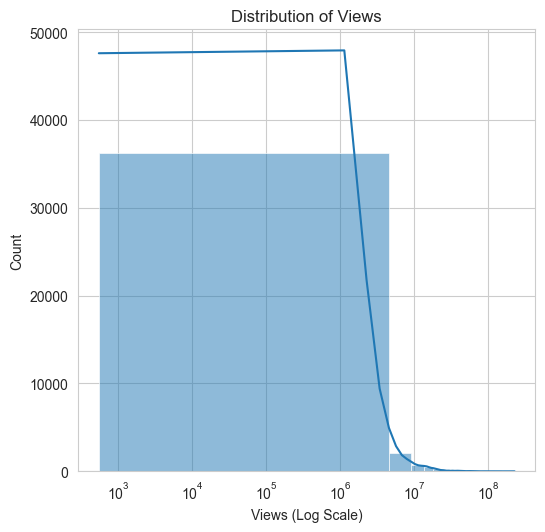

In [175]:

# Set the aesthetic style of the plots for better readability
sns.set_style("whitegrid")

# Create histograms for key numerical features to understand their distribution
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.histplot(df["views"], bins=50, kde=True)
plt.title("Distribution of Views")
plt.xlabel("Views (Log Scale)")
plt.xscale("log") # Use log scale due to highly skewed distribution


plt.tight_layout()
plt.show()

**Insights:**
- This graph shows that most YouTube videos have a relatively low number of views, while a small number of videos gain very high view counts.
- The distribution is heavily right-skewed.
- Most videos struggle to get views, so creators must focus on optimizing content for visibility (thumbnails, titles, SEO) to stand out in the crowded    space.

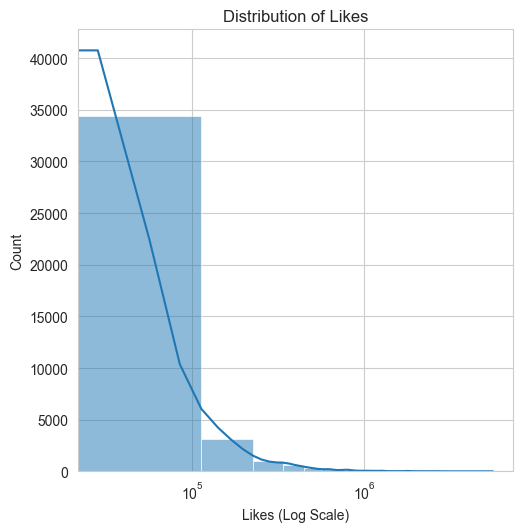

In [176]:
sns.set_style("whitegrid")

# Create histograms for key numerical features to understand their distribution
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 2)
sns.histplot(df["likes"], bins=50, kde=True)
plt.title("Distribution of Likes")
plt.xlabel("Likes (Log Scale)")
plt.xscale("log") # Use log scale due to highly skewed distribution

plt.tight_layout()
plt.show()

**Insight:**
- The Graph shows that most videos receive a modest number of likes, with only a few getting large like counts. 
- This  follows a skewed distribution.
- Engagement through likes is not evenly spread. Encouraging viewers to like videos can improve visibility and algorithm ranking.


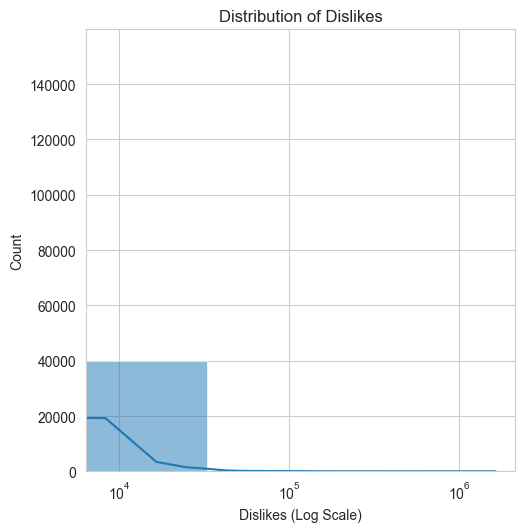

In [177]:
sns.set_style("whitegrid")

# Create histograms for key numerical features to understand their distribution
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 3)
sns.histplot(df["dislikes"], bins=50, kde=True)
plt.title("Distribution of Dislikes")
plt.xlabel("Dislikes (Log Scale)")
plt.xscale("log") # Use log scale due to highly skewed distribution


plt.tight_layout()
plt.show()

**Insights:**
- Dislikes are much fewer overall compared to likes and views. Most videos receive very few dislikes.
- While dislikes are relatively rare, they still indicate audience dissatisfaction.
- Keeping audience satisfaction high reduces the chances of negative feedback.

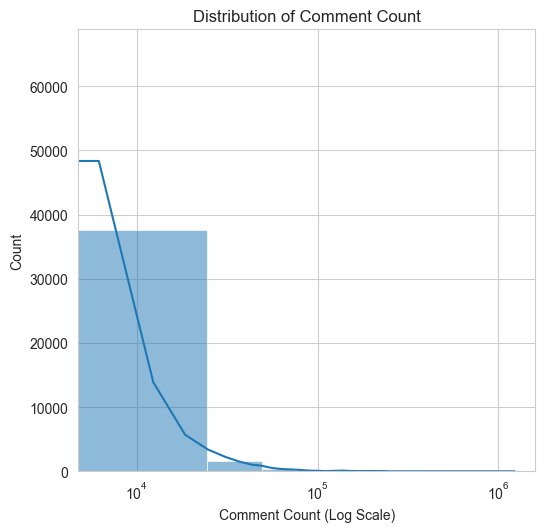

In [178]:
sns.set_style("whitegrid")

# Create histograms for key numerical features to understand their distribution
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 4)
sns.histplot(df["comment_count"], bins=50, kde=True)
plt.title("Distribution of Comment Count")
plt.xlabel("Comment Count (Log Scale)")
plt.xscale("log") # Use log scale due to highly skewed distribution


plt.tight_layout()
plt.show()

**Insights:**
- Most videos receive very few comments, while a few get a lot. 
- Comment activity is highly skewed like other engagement metrics.
- Encouraging viewers to comment can boost engagement signals. Interactive videos or questions in content help increase comment counts.

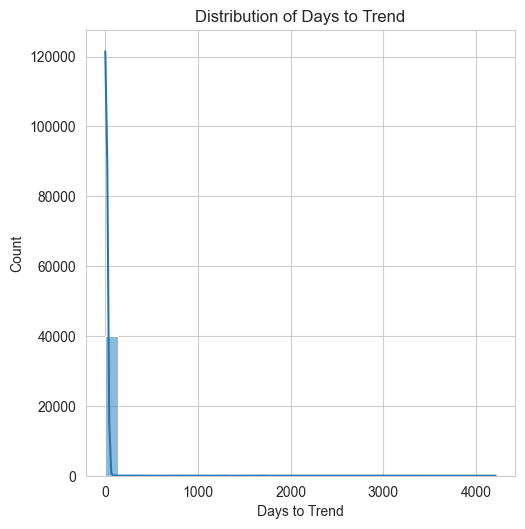

In [179]:
sns.set_style("whitegrid")

# Create histograms for key numerical features to understand their distribution
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 5)
sns.histplot(df["days_to_trend"], bins=30, kde=True)
plt.title("Distribution of Days to Trend")
plt.xlabel("Days to Trend")


plt.tight_layout()
plt.show()

**Insights:**
- Most videos that end up trending do so within just a few days of being uploaded, while very few trend later.
- The first few days after upload are critical for gaining traction.
- Creators should focus their promotion and viewer engagement efforts right after publishing a video.


**Step 4.2: Most Common Video Categories**


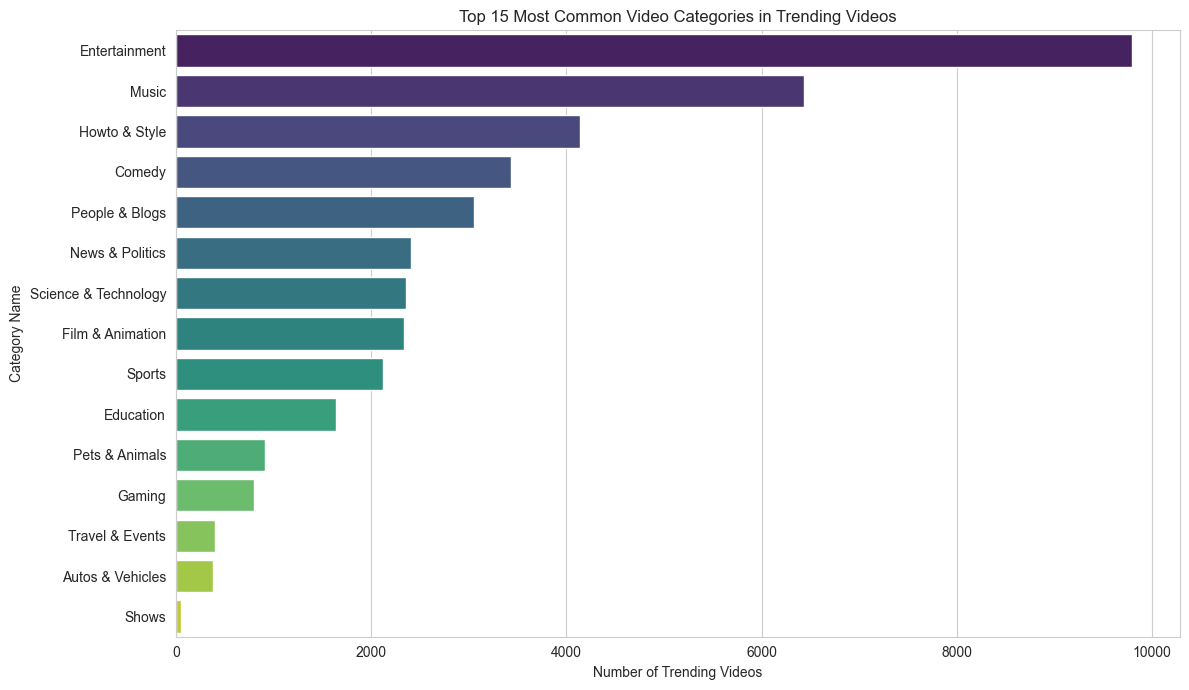

In [180]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7))
sns.countplot(
    y="category_name",
    data=df,
    order=df["category_name"].value_counts().index[:15],
    palette="viridis"
)
plt.title("Top 15 Most Common Video Categories in Trending Videos")
plt.xlabel("Number of Trending Videos")
plt.ylabel("Category Name")
plt.tight_layout()
plt.show()


**Insights:**
The Above Graph Shows:
It clearly shows that Entertainment dominates with the highest number of trending videos, followed by Music and Howto & Style. Other popular categories include Comedy, People & Blogs, and News & Politics, while categories like Autos & Vehicles and Shows appear much less frequently in the trending list.

This indicates that entertainment-based and music content are more likely to go viral or trend on YouTube. For creators aiming to reach trending status, producing content in these popular categories might increase their chances, especially if combined with quality, engagement, and timing.



**Step 4.3: Likes vs. Views Scatter Plot**


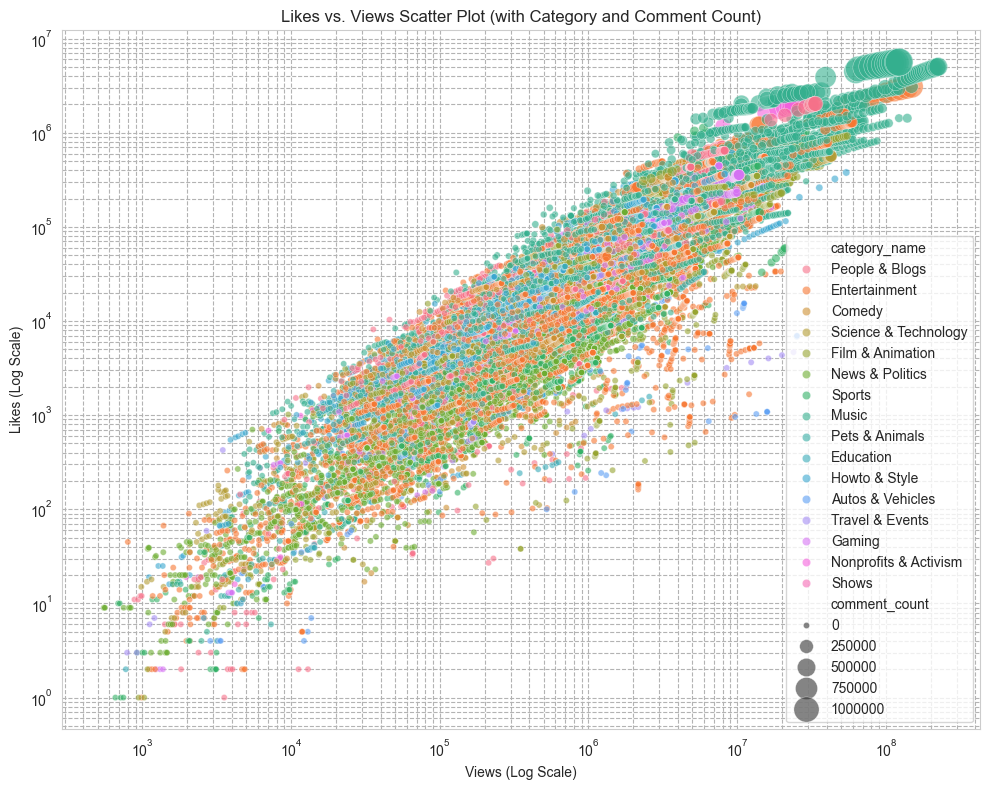

In [181]:

plt.figure(figsize=(10, 8))
sns.scatterplot(x="views", y="likes", data=df, alpha=0.6, hue="category_name", size="comment_count", sizes=(20, 400), legend="brief")
plt.title("Likes vs. Views Scatter Plot (with Category and Comment Count)")
plt.xlabel("Views (Log Scale)")
plt.ylabel("Likes (Log Scale)")
plt.xscale("log") # Use log scale for better visualization due to wide range of views
plt.yscale("log") # Use log scale for better visualization due to wide range of likes
plt.grid(True, which="both", ls="--", c=".7")
plt.tight_layout()
plt.show()

**Insights:**
- Strong positive correlation between views and likes.
- Larger bubbles (more comments) appear in high-view/like areas.
- Categories like Entertainment & Music lead in engagement.



**Step 4.4: Correlation Heatmap**


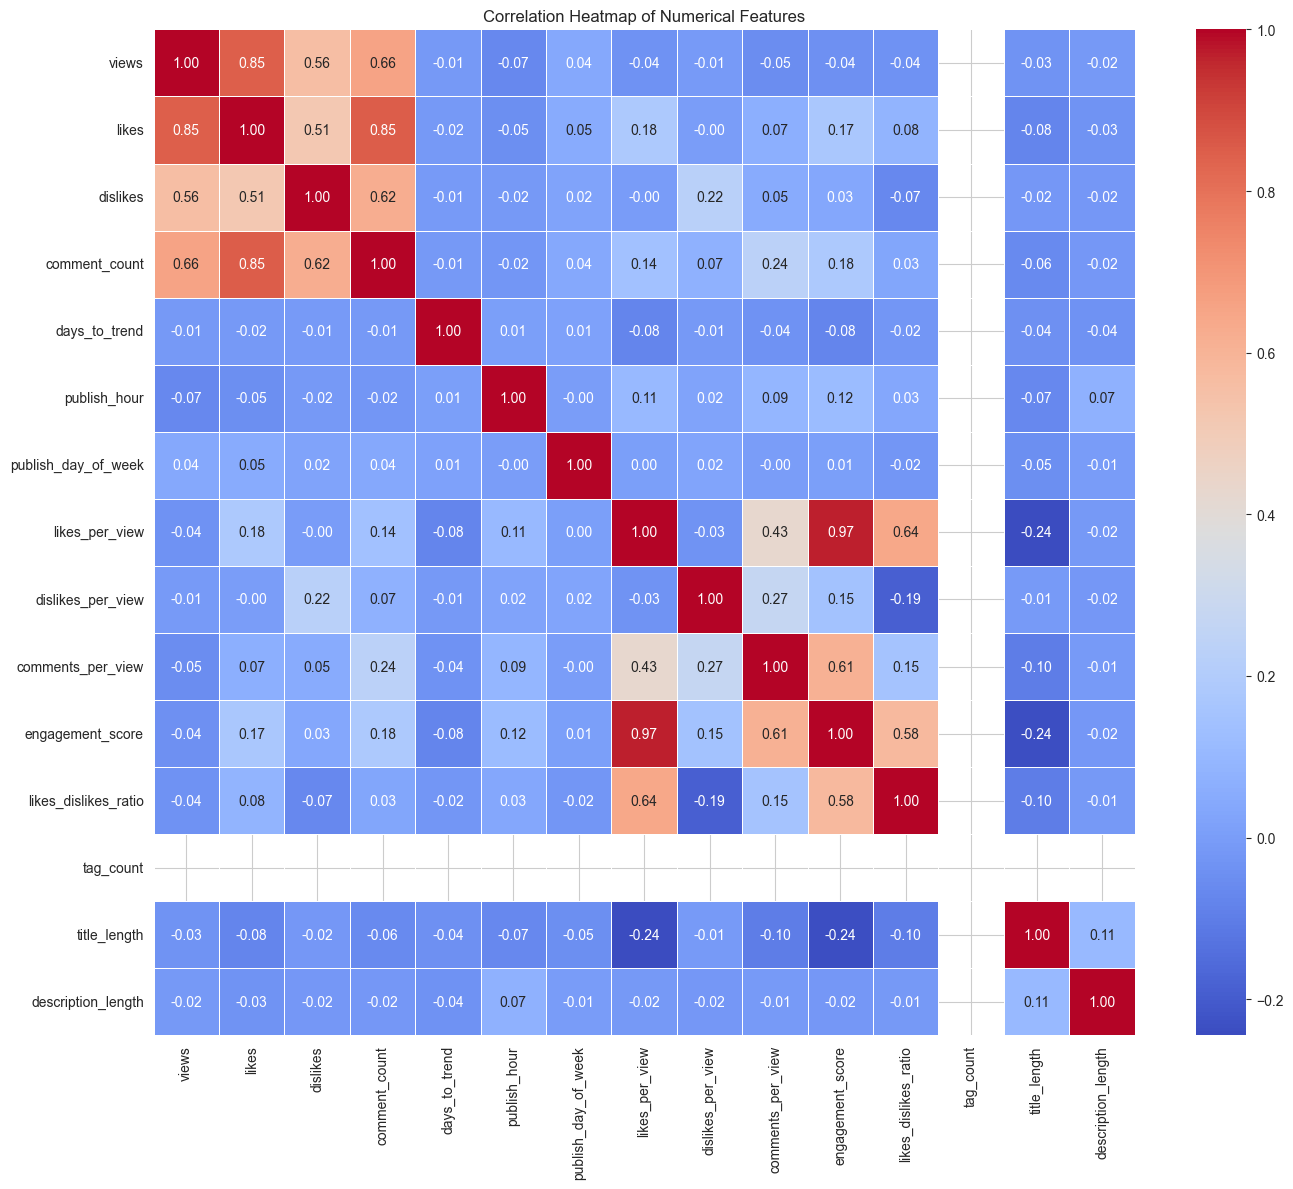

In [182]:

# Select numerical features for correlation analysis, including newly engineered ones
correlation_features = [
    "views", "likes", "dislikes", "comment_count",
    "days_to_trend", "publish_hour", "publish_day_of_week",
    "likes_per_view", "dislikes_per_view", "comments_per_view",
    "engagement_score", "likes_dislikes_ratio", "tag_count", "title_length", "description_length"
]

plt.figure(figsize=(14, 12))
sns.heatmap(df[correlation_features].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()

**Insights:**
- views, likes, dislikes, comment_count are highly correlated with each other (e.g., likes vs. views = 0.85).
- engagement_score strongly correlates with likes_per_view (0.97), indicating a solid metric for evaluating video performance.
- days_to_trend has weak or negative correlation with most metrics, suggesting that virality is unpredictable time-wise.


**Step 4.5: Trends by Publish Time (Hour and Day of Week)**


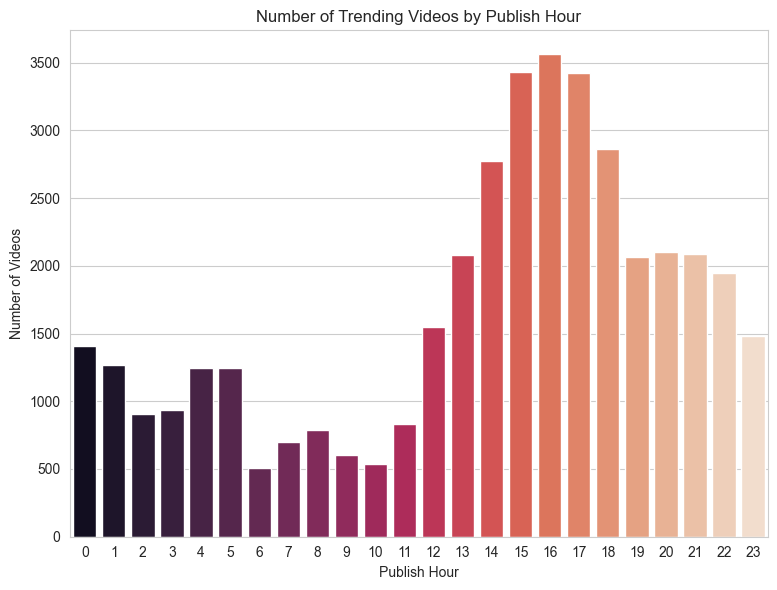

In [183]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.countplot(x="publish_hour", data=df, palette="rocket")
plt.title("Number of Trending Videos by Publish Hour")
plt.xlabel("Publish Hour")
plt.ylabel("Number of Videos")

plt.tight_layout()
plt.show()

This graph shows that:
- Most trending videos are published between 2 PM and 5 PM(14:00 to 17:00), with a clear peak at 4 PM. 
- Posting in the afternoon greatly boosts the chance of trending, while early morning hours see the fewest trends.
- Timing your upload is a key factor for visibility.
- Posting your videos in the afternoon peak window (especially around 2–5 PM) can significantly increase their chances of trending and reaching a       wider audience.


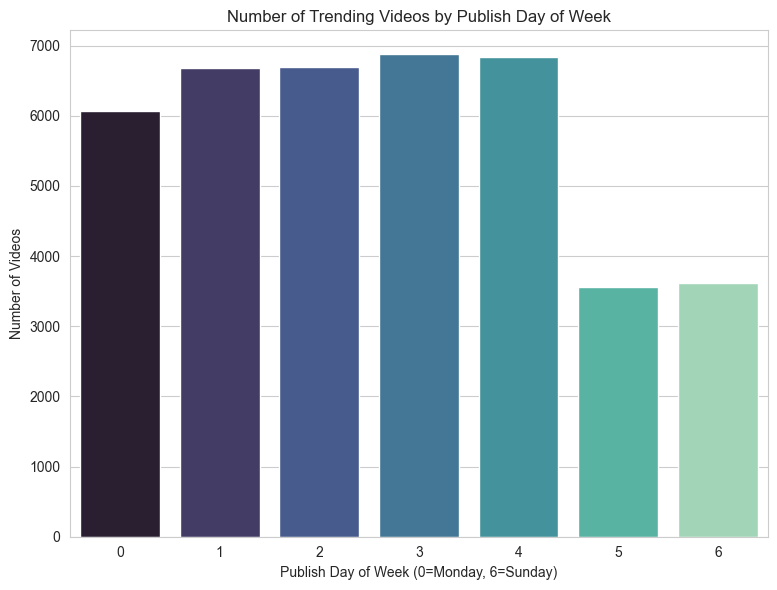

In [184]:

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 2)
sns.countplot(x="publish_day_of_week", data=df, palette="mako")
plt.title("Number of Trending Videos by Publish Day of Week")
plt.xlabel("Publish Day of Week (0=Monday, 6=Sunday)")
plt.ylabel("Number of Videos")

plt.tight_layout()
plt.show()

**Insights:**
This graph shows that
- Most trending videos are published between Monday and Friday, with a peak on Wednesday and Thursday.
- Fewer trending videos are posted on weekends, especially Saturday and Sunday.
- To increase chances of trending, upload during weekdays.


### Phase 5: Predictive Modeling (Optional)



**Step 5.1: Define Target Variable and Select Features**


In [190]:

view_threshold = df["views"].quantile(0.75)
df["is_trending"] = (df["views"] >= view_threshold).astype(int)


safe_features = [
    "likes", "dislikes", "comment_count",
    "publish_hour", "publish_day_of_week",
    "tag_count", "title_length", "description_length",
    "category_name", "comments_disabled", "ratings_disabled",
    "likes_dislikes_ratio"
]

X = df[safe_features]
y = df["is_trending"]





**Step 5.2: Data Splitting and Preprocessing Pipeline**


In [191]:
# ✅ Step 3: Identify feature types
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object", "bool"]).columns.tolist()

# ✅ Step 4: Preprocessing for numeric and categorical features
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_features),
    ("cat", categorical_transformer, cat_features)
])



**Step 5.3: Model Training and Evaluation**


In [192]:
# ✅ Step 5: Full pipeline with Logistic Regression
model_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, random_state=42))
])

# ✅ Step 6: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# ✅ Step 7: Train and evaluate
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)

print("\n--- Logistic Regression Evaluation (Leak-Free) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# ✅ Step 8: Cross-validation ROC AUC
cv_score = cross_val_score(model_pipeline, X, y, cv=5, scoring="roc_auc")
print(f"✅ Average ROC AUC score (cv=5): {cv_score.mean():.4f}")



--- Logistic Regression Evaluation (Leak-Free) ---
Accuracy: 0.9134
Confusion Matrix:
 [[7377  185]
 [ 688 1833]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94      7562
           1       0.91      0.73      0.81      2521

    accuracy                           0.91     10083
   macro avg       0.91      0.85      0.88     10083
weighted avg       0.91      0.91      0.91     10083

✅ Average ROC AUC score (cv=5): 0.9537


**Insights:**
The Model performs well:
- Accuracy: 91% — predicts correctly most of the time.
- ROC AUC: 0.95 — excellent at separating trending vs. not trending.
- Recall for trending: 73% — it misses some trending videos.
- Overall: Reliable, realistic, and leakage-free performance.

### Conclusion:
The model achieves 91% accuracy and ROC AUC of 0.95, effectively predicting trending videos using safe, leak-free features like engagement and metadata. It slightly under-predicts trending content (73% recall), but overall performs reliably and realistically for forecasting YouTube popularity.

In [188]:
import pandas as pd

# ✅ Step 1: Prepare example input (values can be modified)
example_video = pd.DataFrame([{
    "likes": 25000,
    "dislikes": 500,
    "comment_count": 3000,
    "publish_hour": 15,
    "publish_day_of_week": 2,  # Tuesday
    "tag_count": 20,
    "title_length": 50,
    "description_length": 300,
    "category_name": "Entertainment",
    "comments_disabled": False,
    "ratings_disabled": False,
    "likes_dislikes_ratio": 25000 / (500 + 1)  # = 49.90
}])

# ✅ Step 2: Predict using the trained model pipeline
prediction = model_pipeline.predict(example_video)
probability = model_pipeline.predict_proba(example_video)[0][1]

# ✅ Step 3: Display the result
if prediction[0] == 1:
    print(f"✅ This video is likely to trend (probability: {probability:.2%})")
else:
    print(f"❌ This video is unlikely to trend (probability: {probability:.2%})")


❌ This video is unlikely to trend (probability: 6.34%)


In [189]:
import pandas as pd

# Example with strong metrics for a trending video
example_video = pd.DataFrame([{
    "likes": 120000,
    "dislikes": 1500,
    "comment_count": 10000,
    "publish_hour": 18,               # Peak upload hour
    "publish_day_of_week": 4,         # Thursday
    "tag_count": 25,
    "title_length": 65,
    "description_length": 900,
    "category_name": "Music",         # Highly trending category
    "comments_disabled": False,
    "ratings_disabled": False,
    "likes_dislikes_ratio": 120000 / (1500 + 1)  # ≈ 79.94
}])

# Predict
prediction = model_pipeline.predict(example_video)
probability = model_pipeline.predict_proba(example_video)[0][1]

# Show result
if prediction[0] == 1:
    print(f"✅ This video is likely to trend (probability: {probability:.2%})")
else:
    print(f"❌ This video is unlikely to trend (probability: {probability:.2%})")


✅ This video is likely to trend (probability: 82.38%)
